# Amino Acid Cross Feeding
Comparing the effect of altering which amino acids are used for the auxotrophic interaction on the growth rates in community.

### Identify Relevant AA Rxns/Genes

In [46]:
import cobra.io

model_paths = ["../../data/GD.xml", "../../data/AG.xml"]
models = []

for i in range(len(model_paths)):
    models.append(cobra.io.read_sbml_model(model_paths[i]))

# Convienince
GD = models[0]
AG = models[1]

In [47]:
AAids = [
    "ala_L", "arg_L", "asn_L", "asp_L",
    "cys_L",
    "gln_L","glu_L", "gly",
    "his_L",
    "ile_L",
    "leu_L", "lys_L",
    "met_L",
    "phe_L", "pro_L",
    "ser_L",
    "thr_L", "trp_L", "tyr_L",
    "val_L"
    ]

AAnames = [
    "L-Alanine",
    "L-Arginine",
    "L-Asparagine",
    "L-Aspartate",
    "L-Cysteine",
    "L-Glutamine",
    "L-Glutamate",
    "Glycine",
    "L-Histidine",
    "L-Isoleucine",
    "L-Leucine",
    "L-Lysine",
    "L-Methionine",
    "L-Phenylalanine",
    "L-Proline",
    "L-Serine",
    "L-Threonine",
    "L-Tryptophan",
    "L-Tyrosine",
    "L-Valine"
    ]

In [48]:
def get_aa_mets(m):
    '''
    - Find Aminio Acid metabolites in model
    - This does a pretty good job of finding the metabolites as they have all been named conventionally.
    - Assumes that synthesis of aa's only occurs in cytosol (may be erroneous)
    
    Returns: list of metabolite objects whose name matches the amino acids in the list
    '''
    aa = []
    # AAnames is global var 
    for met in AAnames:
        for i in m.metabolites:
            # if met == i.name:
            # Does this assumption need to be revised?
            if met == i.name and i.compartment == "c":
                # print(i.name,i.compartment)
                aa.append(i)
        # print()
    return aa # 

# aa = print(get_aa_mets(AG)) # for dev
aa = get_aa_mets(AG) # for dev

In [49]:
# The summary method provides access to a list of reactions that can have producing flux.
# this is in the producing_flux attribute.
# a = temp.summary()
a = aa[len(aa)-2].summary() # Just pick one at random
# type(a.producing_flux.reaction) # pandas series of reactions that produce metabolite A 
# So we can use this to identify the reactions that produce each amino acid in the model, 
# this is simpler if we know which compartment the 'core' aa is created in.
a.producing_flux

,flux,reaction,percent
TYRTA,0.113012,TYRTA,1.0
TYRt2rpp,0.000000,TYRt2rpp,0.0


In [50]:
def findProducing_Genes(model,met):
    '''
    Takes met, a metabolite object from a cobra model.
    Prints details
         and returns a list of producing reactions 
         and returns a list of genes associated with these reactions
    
    '''
    ret_rxns = []
    assoc_genes = set()

    a = met.summary()
    print( f"Number of reactions producing {met.id, met.name}: ", len(a.producing_flux.reaction))
    gene_count = 0 
    for rxn_id in a.producing_flux.reaction:
        try:
            rxn_obj = [i for i in model.reactions if rxn_id == i.id][0]
            print("   ",rxn_obj.id," ",rxn_obj.name ,": " )
            print("    ",rxn_obj.reaction)
            print("    ",rxn_obj.gene_reaction_rule)
            ret_rxns.append(rxn_obj)
            # Find reaction object in model and count number of genes associated.
            t_associated_genes = [j for j in rxn_obj.genes] # temp var for storing associated genes to a given reaction
            if len(t_associated_genes) == 0: 
                print("    No associated genes for this reaction, may occur spontaneously")
            for g in t_associated_genes:
                # print("     ",g.id)#
                assoc_genes.add(g)
        except:
            print(f"Unable to find {rxn_id} in {model.name}")

    print("   Genes Associated With Production: ",len(assoc_genes),"\n" )
    return ret_rxns, assoc_genes

findProducing_Genes(AG,aa[len(aa)-2]) # Tyrosine

Number of reactions producing ('tyr__L_c', 'L-Tyrosine'):  2
    TYRTA   Tyrosine transaminase : 
     akg_c + tyr__L_c <=> 34hpp_c + glu__L_c
     b4054 or b0928
    TYRt2rpp   L-tyrosine reversible transport via proton symport (periplasm) : 
     h_p + tyr__L_p <=> h_c + tyr__L_c
     b1473 or b1907 or b0112 or b0576
   Genes Associated With Production:  6 



([<Reaction TYRTA at 0x2ad8fb0dc00>, <Reaction TYRt2rpp at 0x2ad8fb0d2d0>],
 {<Gene b0112 at 0x2ad12706bc0>,
  <Gene b0576 at 0x2ad12636b30>,
  <Gene b0928 at 0x2ad753bed70>,
  <Gene b1473 at 0x2ad12636bc0>,
  <Gene b1907 at 0x2ad12637340>,
  <Gene b4054 at 0x2ad753bfc70>})

In [51]:
def checkSynthesis(reaction,tgt):
    '''
    Both inputs are cobra model objects.
    Takes a reaction and target metabolite to check if the metabolite species appears on both sides of the reaction.
    If yes the reaction is assumed to be some sort of transport and not a synthesis reaction.
    The context is the assement of reactions identified as producers of a target amino acid 
    metabolite by the metabolite.summary() functiion 
    '''
    c = 0
    for r in reaction.metabolites:
        if r.name == tgt.name:
            c +=1
        # print(r.name,c)
        
    if c>1:
        return False
    else:
        return True   

# Simple test
test = AG.reactions.TYRt2rpp
print(checkSynthesis(test,aa[len(aa)-2]))
print()
test = AG.reactions.TYRTA
print(checkSynthesis(test,aa[len(aa)-2]))

# So from this we reduce the pool of 'production' reactions for each metabolite to those that are relevant
# These can then be assesed in terms of number of genes?

False

True


In [52]:
# Take the 'production' reactions identified and screen them to see if they synthesise
models = [AG,GD]
model_prdct_rxns = []
for m in models:
    aa = get_aa_mets(m)
    ans= {}
    for amino_acid in aa:
        ans[amino_acid.name] = []
        reacts, genes = findProducing_Genes(m,amino_acid)
        for r in reacts:
            if checkSynthesis(r,amino_acid):
                # print(r.name)
                ans[amino_acid.name].append(r)
    model_prdct_rxns.append(ans)

Number of reactions producing ('ala__L_c', 'L-Alanine'):  9
    ALATA_L   L-alanine transaminase : 
     akg_c + ala__L_c <=> glu__L_c + pyr_c
     b2290 or b2379
    ALAabcpp   L-alanine transport via ABC system (periplasm) : 
     ala__L_p + atp_c + h2o_c --> adp_c + ala__L_c + h_c + pi_c
     b3454 and b3455 and b3457 and b3460 and b3456
    ALAt2pp_copy1   L-alanine transport in via proton symport (periplasm) : 
     ala__L_p + h_p --> ala__L_c + h_c
     b4208
    ALAt2pp_copy2   L-alanine transport in via proton symport (periplasm) : 
     ala__L_p + h_p <=> ala__L_c + h_c
     
    No associated genes for this reaction, may occur spontaneously
    ALAt4pp   L-alanine transport in via sodium symport (periplasm) : 
     ala__L_p + na1_p --> ala__L_c + na1_c
     b0007
    CYSSADS   L-cysteine sulfinic acid desulfurase : 
     3sala_c + 2.0 h_c --> ala__L_c + so2_c
     b2810
    ICYSDS   ISC Cysteine desulfuration : 
     cys__L_c + iscs_c --> ala__L_c + iscssh_c
     b2530
    LA

In [53]:
# Sense Check
print(len(model_prdct_rxns[0]),len(model_prdct_rxns[1])) # check we have all 20 aa's

# Find metabolites that do not have production pathways in the models
# as expected this shows that the AG model cannot produce phenylalanine and the GD strain Tyrosine.  
for i in range(len(models)):
    mind = i
    for a in model_prdct_rxns[mind].keys():
        if len(model_prdct_rxns[mind][a]) == 0:
            print(a)


20 20
L-Phenylalanine
L-Tyrosine


In [54]:
AG_genRelCount = []
GD_genRelCount = []

# model_prdct_rxns[0].keys()
print("AG amino Acid Gene Relationships")
for AmAc in model_prdct_rxns[0].keys():
    s = set()
    for i in model_prdct_rxns[0][AmAc]:
        for j in i.genes:
            s.add(j)
    AG_genRelCount.append(len(s))
    print(f"Min num of genes related to {AmAc} " , len(s))


print("\nGD Amino Acid Gene Relationships")
for AmAc in model_prdct_rxns[1].keys():
    s = set()
    for i in model_prdct_rxns[1][AmAc]:
        for j in i.genes:
            s.add(j)
    GD_genRelCount.append(len(s))
    print(f"Min num of genes related to {AmAc} " , len(s))



AG amino Acid Gene Relationships
Min num of genes related to L-Alanine  7
Min num of genes related to L-Arginine  1
Min num of genes related to L-Asparagine  2
Min num of genes related to L-Aspartate  3
Min num of genes related to L-Cysteine  6
Min num of genes related to L-Glutamine  2
Min num of genes related to L-Glutamate  30
Min num of genes related to Glycine  7
Min num of genes related to L-Histidine  1
Min num of genes related to L-Isoleucine  1
Min num of genes related to L-Leucine  2
Min num of genes related to L-Lysine  2
Min num of genes related to L-Methionine  12
Min num of genes related to L-Phenylalanine  0
Min num of genes related to L-Proline  5
Min num of genes related to L-Serine  2
Min num of genes related to L-Threonine  1
Min num of genes related to L-Tryptophan  4
Min num of genes related to L-Tyrosine  2
Min num of genes related to L-Valine  2

GD Amino Acid Gene Relationships
Min num of genes related to L-Alanine  7
Min num of genes related to L-Arginine  1
Mi

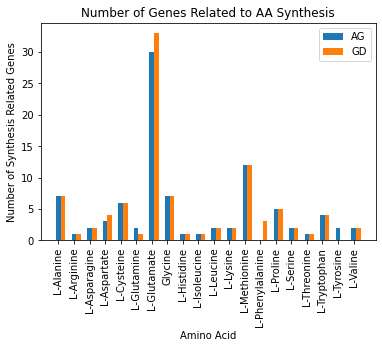

In [55]:
# Lets just quickly graph the number of genes involved in the production of each metabolite.
# this is likely not an exhaustive count
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# plot these on simple bar chart with amino acid names on the x axis
# AG_genRelCount
# GD_genRelCount
width = 0.3
x = np.arange(len(AG_genRelCount))

fig,ax =  plt.subplots()
ax.tick_params("x", rotation=90)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Number of Synthesis Related Genes")
ax.set_xticks(x,list(model_prdct_rxns[0].keys()))
ax.set_title("Number of Genes Related to AA Synthesis")

plt.bar(x, AG_genRelCount,width=width, label = "AG")
plt.bar(x+width, GD_genRelCount, width=width, label="GD")
ax.legend()
plt.show()

In [56]:
# Estabish cross feeding candidates: 
cutoff = 1 # The number of genes associated to production above which we do not wish to consider.

print("AG")
c = 0
ko_tgt_aa_AG = []
for i in range(len(AG_genRelCount)):
    if AG_genRelCount[i] <= cutoff and AG_genRelCount[i] > 0:
        t = list(model_prdct_rxns[0].keys())[i]
        print(t) 
        ko_tgt_aa_AG.append(t)
        c +=1
print(c)

print("GD")
c = 0
ko_tgt_aa_GD = []
for i in range(len(GD_genRelCount)):
    if GD_genRelCount[i] <= cutoff and GD_genRelCount[i] > 0:
        t = list(model_prdct_rxns[1].keys())[i]
        print(t)
        ko_tgt_aa_GD.append(t)
        c +=1
print(c)



AG
L-Arginine
L-Histidine
L-Isoleucine
L-Threonine
4
GD
L-Arginine
L-Glutamine
L-Histidine
L-Isoleucine
L-Threonine
5


In [57]:
# Generalise the above to test all single knockout options:
# Aim here is to eyeball the expected behavior, if a knock out fails then discard from further testing.
# Those that pass can be added to the list for pairwise combination testing of knockouts.

totest = [ko_tgt_aa_AG, ko_tgt_aa_GD]

for x in totest:
    ind = 0
    for tgt in x:
        print("testing: ", tgt)
        c = 0
        with AG as m: 
            x = m.slim_optimize()
            c+=1 if x > 0 else 0
            print("Initial Optimization: ", x) # should be viable
            for gene in model_prdct_rxns[ind][tgt][0].genes:
                print(gene)
                [i for i in m.genes if i.id == gene.id][0].knock_out()          
            
            x = m.slim_optimize()
            c+=1 if x == 0 else 0
            print("Dead:", x) # should not be able to grow
            
            # Allow uptake of amino acid from medium: 
            for i in m.reactions: 
                if tgt + " exchange" in i.name:
                    print(i.name, i.bounds)
                    i.bounds = (-10,1000)
            # m.reactions.EX_arg__L_e.bounds = (-10,1000)

            x = m.slim_optimize()
            c+=1 if x > 0 else 0
            print("Restored", x) # Should restore viability, interestingly seems to increase growth
            print("Test complete: ","Passed" if c==3 else "Failed" ,"\n\n")

    ind +=1 


testing:  L-Arginine
Initial Optimization:  0.8182241571069291
b3960
Dead: 0.0
L-Arginine exchange (0.0, 1000.0)
Restored 1.7041991593991663
Test complete:  Passed 


testing:  L-Histidine
Initial Optimization:  0.8182241571069281
b2020
Dead: 0.0
L-Histidine exchange (0.0, 1000.0)
Restored 0.8269726803572447
Test complete:  Passed 


testing:  L-Isoleucine
Initial Optimization:  0.8182241571069319
b3770
Dead: 0.0
L-Isoleucine exchange (0.0, 1000.0)
Restored 0.8506774906463521
Test complete:  Passed 


testing:  L-Threonine
Initial Optimization:  0.8182241571069305
b0004
Dead: 0.0
L-Threonine exchange (0.0, 1000.0)
Restored 1.4781765533234852
Test complete:  Passed 


testing:  L-Arginine
Initial Optimization:  0.8182241571069284
b3960
Dead: 0.0
L-Arginine exchange (0.0, 1000.0)
Restored 1.704199159399165
Test complete:  Passed 


testing:  L-Glutamine
Initial Optimization:  0.8182241571069278
b3870
b1297
Dead: 0.0
L-Glutamine exchange (0.0, 1000.0)
Restored 1.5710745216516195
Test comp

In [25]:
# # First select shortlist on the follwing list:
# # AG
# # L-Arginine
# # L-Histidine
# # L-Isoleucine
# # L-Threonine

# # GD
# # L-Arginine
# # L-Glutamine
# # L-Histidine
# # L-Isoleucine
# # L-Threonine

# AG_targets_str = ["L-Arginine","L-Histidine","L-Isoleucine","L-Threonine"]
# GD_targets_str = ["L-Arginine","L-Histidine","L-Isoleucine","L-Threonine","L-Glutamine"]

# AG_targets = {}
# GD_targets = {}
# for i in AG_targets_str:
#     AG_targets[i] = model_prdct_rxns[0][i]

# for i in GD_targets_str:
#     GD_targets[i] = model_prdct_rxns[1][i]
    
# with AG as m:
#     for i in AG_targets.keys():
#         rxn_names = {}
#         for j in AG_targets[i]:
#             for x in m.reactions:
#                 if x.id == j.id:
#                     rxn_names[i] = x
#                     # This should be the list of reactions for the amino acid i
#                     # but in the temp context.
#         # print(rxn_names)
#         for j in rxn_names.keys():
#             # Knock out each amino acid production and check feasibility.
            
#             print(f"Testing KO: {j}")


# ## Honestly not sure what the point of this is?

## Apply to community

In [31]:
import micom as mc
com = mc.load_pickle("../../data/community.pickle")

Read LP format model from file C:\Users\domin\AppData\Local\Temp\tmp748u3kx8.lp
Reading time = 0.15 seconds
: 4042 rows, 11287 columns, 43241 nonzeros


In [32]:
# Restore Phenylalanine and Tyrosine
# This is a bodge, affectigng the reactions directly - is there a way to restore gene function cleanly?

# Phenylalanine
# com.genes.b0002.name
com.reactions.PPNDH__AG_uc.upper_bound = 1000 # active reaction that gene

# Tyrosine:
com.reactions.PPND__GD_uc.upper_bound = 1000

In [33]:
com.cooperative_tradeoff(fraction=0.5, fluxes = True, pfba=True)

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AG_uc,0.5,0.911178,2587,1808
GD_uc,0.5,0.911319,2705,1880
medium,NaN,NaN,351,351


In [79]:
# The gene ids in the commnity model are consistant with the ind models
# therefore reuse same logic with the nested loops by tgt reaction.
import pickle
c = 1
for tgt_m1 in ko_tgt_aa_AG:
    for tgt_m2 in ko_tgt_aa_GD:
        print("Combination ", c)
        # Prevent the same aa being knocked out across both models
        if tgt_m1 == tgt_m2:
            continue
        with com:
            # Clean com copy each iteration
            print("AG testing: ", tgt_m1)
            print("GD testing: ", tgt_m2)

            # Knock out genes realating to the first aa target for AG
            for gene in model_prdct_rxns[0][tgt_m1][0].genes:
                print("   AG KO: ", gene)
                [i for i in com.genes if i.id == gene.id][0].knock_out()  

            # Knock out genes relating to the target aa for GD:
            for gene in model_prdct_rxns[1][tgt_m2][0].genes:
                    print("    GD KO: ", gene)
                    [i for i in com.genes if i.id == gene.id][0].knock_out()  

            # Solve with a community Tradeoff 
            try:
                # sol = com.cooperative_tradeoff(fraction=0.97,fluxes = True,pfba=True)
                sol = com.optcom('original')
                print(sol.objective_value,sol.members)
                with open(f"AAResults/optcom/solAux_{tgt_m1}_{tgt_m2}.pickle", 'wb') as fp:
                    # Naming convention: community auxotrophic AG_GD
                    pickle.dump(sol,fp)
                with open(f"AAResults/optcom/comAux_{tgt_m1}_{tgt_m2}.pickle", 'wb') as fp:
                    # Naming convention: community auxotrophic AG_GD
                    pickle.dump(com,fp)
            except:
                with open("AAResults/optcom/failed.txt","a") as fp:
                    fp.write(f"{tgt_m1}_{tgt_m2}\n")

            # Limit while testing
        c += 1
    #     if c == 2:
    #         break
    # break


Combination  1
Combination  1
AG testing:  L-Arginine
GD testing:  L-Glutamine
   AG KO:  b3960
    GD KO:  ECD_03755
1.8202326319176394               abundance  growth_rate  reactions  metabolites
compartments                                                
AG_uc               0.5     3.640465       2587         1808
GD_uc               0.5     0.000000       2705         1880
medium              NaN          NaN        351          351
Combination  2
AG testing:  L-Arginine
GD testing:  L-Histidine
   AG KO:  b3960
    GD KO:  ECD_01922
1.8202326319176063               abundance  growth_rate  reactions  metabolites
compartments                                                
AG_uc               0.5     3.640465       2587         1808
GD_uc               0.5     0.000000       2705         1880
medium              NaN          NaN        351          351
Combination  3
AG testing:  L-Arginine
GD testing:  L-Isoleucine
   AG KO:  b3960
    GD KO:  ECD_03648
1.8202326319176043         

Next:
Okay so we've run through 17 combinations of amino acid knock-outs and generated solutions as well as saved the models for each of them (overkill)

What do we want to generate from this?   
Do I have a function for obtaining the maximum theoretical yield from any community?  


<CommunitySolution 0.000 at 0x174a5d36170>


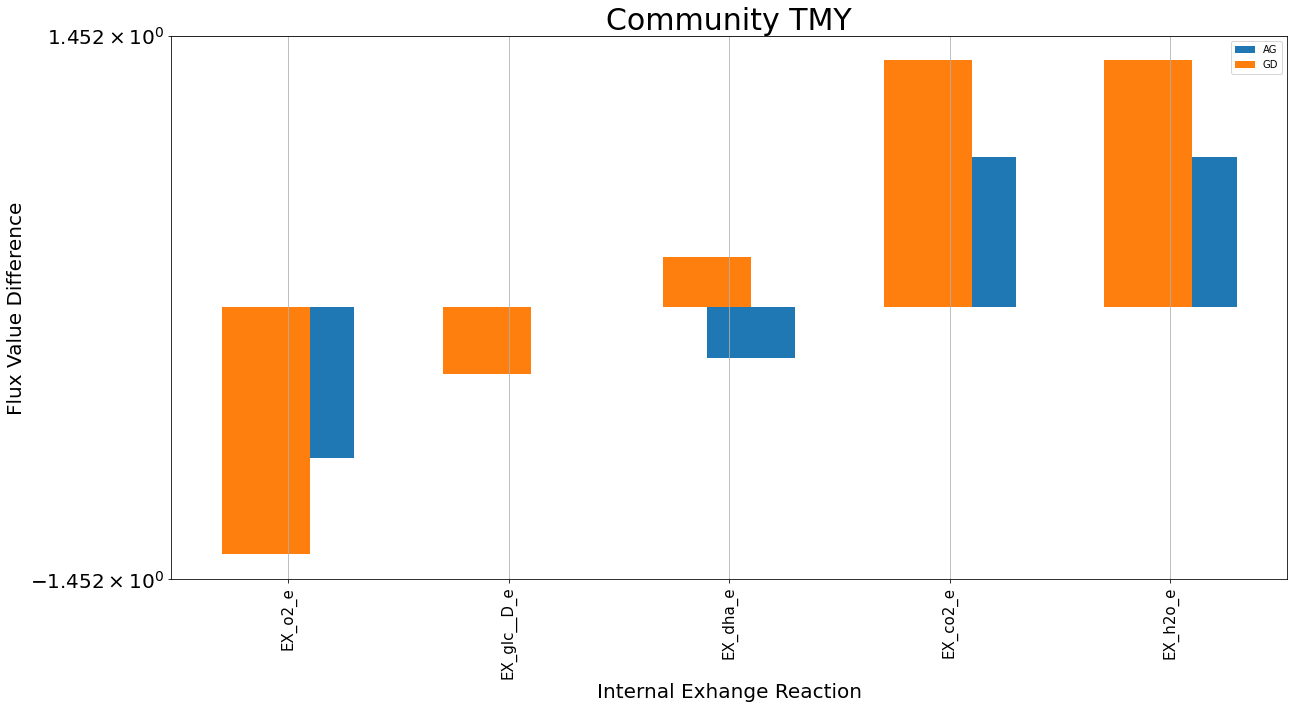

In [61]:
# with com as m:
#     m.objective = "SALIDROSIDE_BIOSYNTHESIS__GD_uc"
#     x = m.optimize()
#     print(x)

def community_TMY(commodel,tgt_rxn):
    with commodel as m:
        m.objective = tgt_rxn
        return m.optimize(pfba=True, fluxes=True)

x = community_TMY(com, tgt_rxn="SALIDROSIDE_BIOSYNTHESIS__GD_uc")
print(x)
x.objective_value


# from utils import getInternalExchangeFluxes
# from utilPlots import plotIntExchFlux

# temp = getInternalExchangeFluxes(com, x)
# plotIntExchFlux(com, temp, "Community TMY")



In [74]:
# com.reactions.Zn2tex
x.fluxes.T.loc["SALIDROSIDE_BIOSYNTHESIS"]
# x.fluxes.T.

compartment
AG_uc     NaN
GD_uc     0.0
medium    NaN
Name: SALIDROSIDE_BIOSYNTHESIS, dtype: float64

## Analysis of Generated Solutions Growth Rates

In [ ]:
# Quickly pull out each model object with the amino acid combinations and calculate the TMY.
# Just because thats the only real strength of the TMY metric 
# - not expecting there to be any material differnece but can talk abou that.

import os
import pickle
import pandas as pd

fp = "./AAResults/Fraction0_5/"

com_TYR_tgt = "HPAA_ADH__AG_uc"
com_SAL_tgt = "SALIDROSIDE_BIOSYNTHESIS__GD_uc"

aacomTMY = {}
fls = []
for name in os.listdir(fp):
    if name[:3] == "com":
        # print(name)
        i = fp+name
        comb = i[31:-7].replace("_"," & ")
        with open(i,"rb") as fil:
            x = pickle.load(fil)

            # calculate TMY:
            
            # Dabble with constraining growth to proportions of individual growt
            temp = x.optimize_all()

            x.reactions.BIOMASS_Ec_iJO1366_core_53p95M__AG_uc.lower_bound = 0.90 * temp.AG_uc
            x.reactions.BIOMASS_Ec_iHK1487_core__GD_uc.lower_bound = 0.90 * temp.GD_uc
            x.objective = com_TYR_tgt
            gus = round(x.slim_optimize(),2)
            x.objective = com_SAL_tgt
            sug = round(x.slim_optimize(),2)
            
                    # "Combination": comb,
            aacomTMY[comb] = {
                    "AG Tyrosol" : gus,
                    "GD Tyrosol" : sug,
                }
                


In [38]:
aacomTMY

{'L-Arginine & L-Glutamine': {'AG Tyrosol': 2.15, 'GD Tyrosol': 1.31},
 'L-Arginine & L-Histidine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Arginine & L-Isoleucine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Arginine & L-Threonine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Histidine & L-Arginine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Histidine & L-Glutamine': {'AG Tyrosol': 21.42, 'GD Tyrosol': 13.02},
 'L-Histidine & L-Isoleucine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Histidine & L-Threonine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Isoleucine & L-Arginine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Isoleucine & L-Glutamine': {'AG Tyrosol': 2.15, 'GD Tyrosol': 1.31},
 'L-Isoleucine & L-Histidine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Isoleucine & L-Threonine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Threonine & L-Arginine': {'AG Tyrosol': nan, 'GD Tyrosol': nan},
 'L-Threonine & L-Glutamine': {'AG Tyrosol': 2.15, 'GD Tyrosol': 1.31},
 'L-Threoni

In [84]:
fp = "./AAResults/Fraction0_5/"

com_TYR_tgt = "HPAA_ADH__AG_uc"
com_SAL_tgt = "SALIDROSIDE_BIOSYNTHESIS__GD_uc"

aacomTMY = {}
fls = []
for name in os.listdir(fp):
    if name == "comAux_L-Histidine_L-Glutamine.pickle":
        # print(name)
        i = fp+name
        comb = i[31:-7].replace("_"," & ")
        with open(i,"rb") as fil:
            x = pickle.load(fil)

Read LP format model from file C:\Users\domin\AppData\Local\Temp\tmp2yxlpfls.lp
Reading time = 0.07 seconds
: 4042 rows, 11287 columns, 43241 nonzeros


In [83]:
# model_prdct_rxns[0].keys()
print(model_prdct_rxns[0]["L-Histidine"])
print(model_prdct_rxns[0]["L-Glutamine"])
print("No aa", x.optimize_all())
x.reactions.GLNS__GD_uc.upper_bound = 1000
print("with GD GLNS",x.optimize_all())
x.reactions.GLNS__GD_uc.upper_bound = 0
x.reactions.HISTD__AG_uc.upper_bound = 1000
print("with AG HISTD",x.optimize_all())
x.reactions.GLNS__GD_uc.upper_bound = 1000
print("With both", x.optimize_all())

# ????

[<Reaction HISTD at 0x2ad83860e50>]
[<Reaction GLNS at 0x2ad8e83f4c0>]


[17:50:24] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=25371;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=535391;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=813335;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=227378;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=553316;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=754916;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

No aa id
AG_uc    3.644994
GD_uc    3.386610
dtype: float64


[17:50:25] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=908619;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=709739;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=398152;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=869036;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=88929;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=719735;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

with GD GLNS id
AG_uc    3.644994
GD_uc    3.386610
dtype: float64


           WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=670700;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=306220;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=852651;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=389078;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=133974;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=950213;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

with AG HISTD id
AG_uc    3.644994
GD_uc    0.000000
dtype: float64


[17:50:26] WARNING  `optimize_all` is deprecated and will be removed soon :(                       ]8;id=145665;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=657232;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#485\485]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=980185;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=701556;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

           WARNING  `optimize_single` is deprecated and will be removed soon :(                    ]8;id=513249;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py\community.py]8;;\:]8;id=866838;file://c:\Users\domin\Anaconda3\envs\gsmm-3\lib\site-packages\micom\community.py#446\446]8;;\

With both id
AG_uc    3.644994
GD_uc    3.386610
dtype: float64


In [22]:
# Retrieve stored solutions 
import os
import pickle
import pandas as pd

fp = "./AAResults/Fraction0_5/"

fls = []
for name in os.listdir(fp):
    if name[:3] == "sol":
        # print(name)
        fls.append(fp+name)


aofnalf = [] # To store dict objects before conversion into dataframe.

for i in fls:
    with open(i,"rb") as fil:
        x = pickle.load(fil)

    comb = i[31:-7].replace("_"," & ")
    print(comb)

    ag_gr = round(x.members.growth_rate.AG_uc,2)
    gd_gr = round(x.members.growth_rate.GD_uc,2)
    print(ag_gr,gd_gr)
    # break

    aofnalf.append(
        {
            "Combination": comb,
            "AG Growth Rate" : ag_gr,
            "AG TMY": 999, 
            "GD Growth Rate" : gd_gr,
            "GD TMY": 999 
        }
    )


df = pd.DataFrame(aofnalf)
df

    # athletes_file = open("athletes.txt", "rb")
    # athletes = pickle.load(athletes_file)
    # athletes_file.close()
    # print(athletes)






L-Arginine & L-Glutamine
1.82 0.0
L-Arginine & L-Histidine
0.91 0.91
L-Arginine & L-Isoleucine
0.91 0.91
L-Arginine & L-Threonine
0.91 0.91
L-Histidine & L-Arginine
0.91 0.91
L-Histidine & L-Glutamine
0.0 0.0
L-Histidine & L-Isoleucine
0.91 0.91
L-Histidine & L-Threonine
0.91 0.92
L-Isoleucine & L-Arginine
0.91 0.92
L-Isoleucine & L-Glutamine
1.82 0.0
L-Isoleucine & L-Histidine
0.91 0.91
L-Isoleucine & L-Threonine
0.9 0.92
L-Threonine & L-Arginine
0.9 0.92
L-Threonine & L-Glutamine
1.82 0.0
L-Threonine & L-Histidine
0.91 0.91
L-Threonine & L-Isoleucine
0.89 0.93


,Combination,AG Growth Rate,AG TMY,GD Growth Rate,GD TMY
0,L-Arginine & L-Glutamine,1.82,999,0.00,999
1,L-Arginine & L-Histidine,0.91,999,0.91,999
2,L-Arginine & L-Isoleucine,0.91,999,0.91,999
3,L-Arginine & L-Threonine,0.91,999,0.91,999
4,L-Histidine & L-Arginine,0.91,999,0.91,999
5,L-Histidine & L-Glutamine,0.00,999,0.00,999
6,L-Histidine & L-Isoleucine,0.91,999,0.91,999
7,L-Histidine & L-Threonine,0.91,999,0.92,999
8,L-Isoleucine & L-Arginine,0.91,999,0.92,999
9,L-Isoleucine & L-Glutamine,1.82,999,0.00,999
